In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Escolha framework
Iniciei tentando utilizar a biblioteca Pytorch, porém após não conseguir avançar na criação do dataset para treinamento, optei por utilizar o Tensorflow mais o Keras.
Tensorflow e Keras se mostram um pouco mais fáceis de compreender e utilizar, tanto na criação do modelo e , principalmente, na criação do dataset de treino.

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import torch
import torchvision
from torchvision.datasets import DatasetFolder
from torchvision import transforms
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import re
from pydicom import dcmread
from skimage.io import imsave
import os

Alteração do diretório de trabalho para ter acesso aos arquivos do dataset da competição

In [ ]:
INPUTDIR_PATH = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification'
os.chdir(INPUTDIR_PATH)
sorted(os.listdir('train/00000'))

Para facilitar a navegação entre diretórios, criei constantes para as principais pastas que utilizei.
Criado também uma constante como se fosse um enumerador para cada tipo de ressonância.

In [ ]:
# Declaração de constantes
TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test'
mri_types = collections.namedtuple('mri_types', ['FLAIR', 'T1W', 'T1WCE', 'T2W'])
MRI_TYPES = mri_types('FLAIR', 'T1w', 'T1wCE', 'T2w')
PNG_DATASET_DIR = '/kaggle/working/png_dataset'
PNG_TEST_DIR = '/kaggle/working/png_test'
WITH_MGMT_DIR = '/kaggle/working/png_dataset/with_mgmt'
WITHOUT_MGMT_DIR = '/kaggle/working/png_dataset/without_mgmt'


Criado os diretórios para salvar as imagens DICOM, que é o formato da ressonância magnética, convertidos em arquivos PNG.

In [ ]:
os.mkdir(PNG_DATASET_DIR)
os.mkdir(WITH_MGMT_DIR)
os.mkdir(WITHOUT_MGMT_DIR)
os.mkdir(PNG_TEST_DIR)

## Funções auxiliares
Aqui foram criadas três funções auxiliares.

A img_loader(path) é para carregar a imagem DICOM, verificar se é uma imagem vazia e retornar ela no formato de array. Caso o arquivo seja vazio, retorna 0.

A função png_save(path) chama o método acima, verifica se é uma array ou 0 e caso seja um array, converte e salva a imagem DICOM no formato PNG.

imgs_path_finder(folder, patient) percorre todos os pacientes e seus respectivos subdiretórios e retorna o caminho de cada arquivo DICOM de forma ordenada no formato de uma lista.

In [ ]:
def img_loader(path):
    ds = dcmread(os.path.join(INPUTDIR_PATH, path))
    if (ds.pixel_array.sum() != 0):
        arr = ds.pixel_array
        # arr = tf.constant(arr)
        return arr
    else:
        return 0
    
def png_save(path):
    image = img_loader(path)
    if isinstance(image, np.ndarray): 
        fname = path.replace('/', '-')
        fname = fname.replace('dcm', 'png')
        imsave(fname, image)
        
def imgs_path_finder(folder, patient):
    images = []
    image_path = []
    for mri in MRI_TYPES:
        images = sorted(os.listdir(os.path.join(folder, patient, mri)), 
                                                key=lambda file: int(re.sub('[^0-9]', '', file)))
        for img in images:
            path = os.path.join(folder, 
                                patient, 
                                mri,
                                img)
            image_path.append(path)
            print(path)
    return image_path

## Análise exploratória

Verificamos alguns dados do arquivo .csv que contém a classificação de cada paciente para a presença do MGMT ou não da pasta TRAIN do dataset.

In [ ]:
df_label = pd.read_csv("train_labels.csv", dtype={'BraTS21ID':str, 'MGMT_value':int})
df_label.MGMT_value.unique()
df_label.describe()
df_label.head()

Gerado duas variáveis contendo a lista de pacientes do diretório de TRAIN e TEST.

In [ ]:
# Lista os pacientes que fazem parte do diretório de treinamento
train_patients = [subdirs for subdirs in os.listdir(TRAIN_FOLDER)]
print('Número de pacientes no diretório de treino', len(train_patients))

# Lista os pacientes que fazem parte do diretório de teste
test_patients = [subdirs for subdirs in os.listdir(TEST_FOLDER)]
print('Número de pacientes no diretório de teste', len(test_patients))

print('Total de pacientes', len(test_patients)+len(train_patients))

## Função de exclusão de casos com falha no dataset
Na descrição da competição, foi informado que os diretórios dos três pacientes 00109, 00123 e 00709 estavam gerando erro no processo de treinamento e orientavam realizar a exclusão deles.
A função abaixo serve para eliminar as pastas dos três pacientes.

In [ ]:
# Exclusão dos pacientes 00109, 00123, 00709 devido a falha do dataset
patients_delete = ('00109', '00123', '00709')
try:
    for patient in patients_delete:
        df_label = df_label[df_label.BraTS21ID != patient]
        train_patients.remove(patient)
except Exception as err:
    print('erro: ', err)
print('Número de pacientes no diretório de treino', len(train_patients))

Após ordenação dos pacientes e dos arquivos de imagem, aparentemente a busca pelos caminhos da fotos ocorreu mais rápido, por isso eu faço a ordenação das listas de pacientes  abaixo.

In [ ]:
test_patients = sorted(test_patients)
train_patients = sorted(train_patients)

Criado a lista contendo uma tuple com o identificador do paciente, o caminho da imagem DICOM e a classificação de presença de MGMT para o diretório TRAIN.

Criado também a lista com uma tuple com o identificador do paciente e o caminho da imagem DICOM para o diretório TEST. Não foi fornecido no dataset da competição a classificação de MGMT.

In [ ]:
# retorna uma lista de duas dimensões
# necessário a conversão de patient para list de forma que todos os elementos sejam do tipo list
# acrescenta o label de presença de MGMT
images_path = []
for patient in train_patients[:25]:
    images_path.append([
        [patient],
        imgs_path_finder(TRAIN_FOLDER, patient),
        [str(int(df_label[df_label['BraTS21ID']==patient].MGMT_value))]
    ])

test_images_path = []
for patient in test_patients[:10]:
    test_images_path.append([
        [patient],
        imgs_path_finder(TEST_FOLDER, patient)
    ])

## Diretório Imagens Treinamento
Através do código abaixo, verificamos para cada paciente o Label de classificação para MGMT e chamamos as funções auxiliares para carregar e salvar os arquivos PNG na seguinte estrutura:

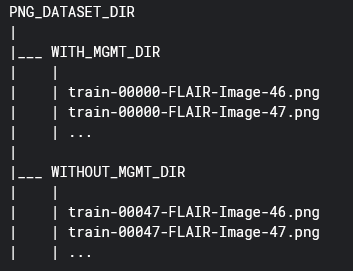\
Esse tipo de estrutura foi utilizado para utilizar as facilidades da biblioteca Keras, que a partir desse formato de diretórios automaticamente gera uma dataset para ser utilizado no treinamento dos modelos de rede neural.
O Keras entende os subdiretórios WITH_MGMT_DIR e WITHOUT_MGMT_DIR como sendo a categoria e fazendo a associação dessa classe a cada imagem dentro do subdiretório.




In [ ]:
for patient in images_path:
    if patient[2][0] == '1':
        os.chdir(WITH_MGMT_DIR)
        for image in patient[1]:
            png_save(image)
        os.chdir(INPUTDIR_PATH)
    else:
        os.chdir(WITHOUT_MGMT_DIR)
        for image in patient[1]:
            png_save(image)
        os.chdir(INPUTDIR_PATH)

Aqui simplesmente buscamos as imagens de cada paciente no diretório TEST, convertemos em PNG e salvamos na pasta PNG_TEST_DIR.

In [ ]:
os.chdir(PNG_TEST_DIR)
for patient in test_images_path:
    for image in patient[1]:
        png_save(image)
os.chdir(INPUTDIR_PATH)

## Keras e Tensorflow

Após especificar o tamanho das nossas imagens e do batch, utilizamos a API do Keras para automaticamente criarmos os datasets de treinamento e validação que iremos utilizar no modelo CNN. Configuramos através dos parâmetros "validation_split" e "subset" a porcentagem de 20% para validação e a divisão do diretório de imagens em dois para treino e validação.

In [ ]:
image_size = (512, 512)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PNG_DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PNG_DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Apenas para exemplificação, pegamos uma amostra do train_ds e plotamos as imagens junto com as respectivas classificações.

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Utilizado o método "prefetch" para agilizar o carregamento dos dados durante o treinamento da rede neural.

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## CNN
De forma experimental, criamos uma rede neural convolucional de apenas oito camadas.

In [ ]:

def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    x = keras.Sequential()
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
   
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)  
     
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,))

model.summary()


Definimos então o número de épocas e uma função para salvar o melhor modelo encontrado durante treinamento.\
Ao compilar o modelo, escolhemos como otimizador o Adam, função de perda do tipo "binary_crossentropy", uma vez que nosso problema é do tipo tem ou não MGMT, e como métrica a acurácia.\
Observando a saída do método "fit", podemos observar que a nossa rede não performa de forma adequada, inclusive aparentemente ela não faz nenhum tipo de aprendizado significativo.

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="/kaggle/working/save_at_{epoch}.h5",
                                    save_best_only=True)
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


## Transferência de aprendizado
Para melhorarmos nossa classificação, optamos por utilizar a transferência de aprendizado de um modelo já pré-treinado. No nosso caso, escolhemos o Xception.\
O próprio Keras fornece um método para obtermos esse modelo com os pesos pré-treinados no dataset do Imagenet.\
Para permitir que o modelo se adeque ao nosso problema, não incluímos a última camada de classificação do Xception ao criarmos nosso modelo base de rede neural.

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(512, 512, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.


Congelamos então os parâmetros do modelo base para não alterarmos os pesos já pré-treinados e criamos a partir dele um novo modelo, adicionando mais duas camdas, sendo a última a nossa camada de classificação.

In [ ]:
base_model.trainable = False

inputs_2 = keras.Input(shape=(512, 512, 3))
x_2 = base_model(inputs_2, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x_2 = keras.layers.GlobalAveragePooling2D()(x_2)
# A Dense classifier with a single unit (binary classification)
outputs_2 = keras.layers.Dense(1, activation="sigmoid")(x_2)
model_2 = keras.Model(inputs_2, outputs_2)
model_2.summary()


Com essa nova rede neural, obtemos uma acurácia próxima de 80%.

In [ ]:
epochs = 20
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="/kaggle/working/transfer_save_at_{epoch}.h5",
                                    save_best_only=True)
]
model_2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model_2.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)


## Utilizando modelo salvo
Depois de termos salvo o melhor modelo durante trainamento, podemos restaurar o mesmo e fazer as nossas classificações.

In [ ]:
#restored_model = keras.models.load_model("/kaggle/input/saved-models/transfer_save_at_17.h5")
#restored_model.summary()
predictions = []
i = 0
for file in os.listdir(PNG_TEST_DIR)[:100]:
    image = tf.keras.preprocessing.image.load_img(os.path.join(PNG_TEST_DIR, file),
                                                  target_size=image_size)
    input_arr = keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])  # Convert single image to a batch.
    predictions.append([file, model_2.predict(input_arr)])
predictions

## Ajuste fino
Através do código abaixo, poderíamos fazer um ajuste final do modelo ao descongelar os parâmetros do modelo base, porém devido as limitações de recursos do ambiente de desenvolvimento, o código abaixo gera erro de Out Of Memory.

In [ ]:
'''
base_model.trainable = True

model_2.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])


model_2.fit(train_ds, epochs=10, callbacks=callbacks, validation_data=val_ds)
'''